# Tracker

### Imports

In [1]:
import json
import mimetypes
import multiprocessing
import os

import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm


### Code for processing a single video

In [6]:
def process_video(video_path, template_path, gui=False, pid=None, save_to_file=None):
    cap = cv.VideoCapture(video_path)
    template = cv.imread(template_path)
    template_w, template_h = template.shape[1], template.shape[0]

    output = None
    if save_to_file:
        output = cv.VideoWriter(save_to_file, cv.VideoWriter.fourcc(*"MPEG"), cap.get(cv.CAP_PROP_FPS), (int(cap.get(cv.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))))

    # Array with video data. columns = [frame_nr, y_from_top, x_from_left]
    # Note: a Python list is used instead of a numpy array because python lists are faster for loops appending to the list.
    # https://towardsdatascience.com/python-lists-are-sometimes-much-faster-than-numpy-heres-a-proof-4b3dad4653ad
    video_data = []

    try:
        # Read until video is completed
        truncated_path = video_path[-20:]
        with tqdm(total=int(cap.get(cv.CAP_PROP_FRAME_COUNT)), desc=f"#{pid} - Processing {truncated_path}", position=pid, leave=False) as pbar:
            while cap.isOpened():
                pbar.update(1)

                # Capture frame-by-frame
                frame_available, frame = cap.read()
                if not frame_available:
                    break

                # Method used by the matching algorithm.
                method = cv.TM_CCOEFF_NORMED

                # If video_data already contains a datapoint, limit the search area to speed up seaching process.
                if len(video_data):
                    last_location = (video_data[-1][1], video_data[-1][2])

                    # Size of the searching area compared to the template size.
                    shape_factor = 1.2

                    y_min = max((last_location[0] - int(shape_factor * template_h)), 0)
                    y_max = max((last_location[0] + int(shape_factor * template_h)), 0)
                    x_min = max((last_location[1] - int(shape_factor * template_w)), 0)
                    x_max = max((last_location[1] + int(shape_factor * template_w)), 0)

                    limited_frame = frame[y_min:y_max, x_min:x_max]
                    limited_result = cv.matchTemplate(limited_frame, template, method)

                    result = np.empty(((frame.shape[0] - template_h + 1), (frame.shape[1] - template_w + 1)))

                    result[y_min:(y_min + limited_result.shape[0]), x_min:(x_min + limited_result.shape[1])] = limited_result

                    # Draw searching area.
                    cv.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
                else:
                    result = cv.matchTemplate(frame, template, method)

                # Threshold for a positive result.
                threshold = 0.8
                if np.max(result) >= threshold:
                    loc = np.where(result == np.max(result))

                    top_left = np.array([loc[0][0], loc[1][0]])
                    bottom_right = (top_left[0] + template_h, top_left[1] + template_w)

                    # Draw template region.
                    # Please note: cv.rectangle uses (x,y) instead of (y,x) like numpy does. Therefore array is turned around using [::-1]
                    cv.rectangle(frame, top_left[::-1], bottom_right[::-1], (255, 0, 0), 2)

                    # Saving datapoint to video_data.
                    frame_nr = int(cap.get(cv.CAP_PROP_POS_FRAMES))
                    y_from_top = (top_left[0] + bottom_right[0]) // 2
                    x_from_left = (top_left[1] + bottom_right[1]) // 2

                    video_data.append([frame_nr, y_from_top, x_from_left])

                    # Draw tracked point.
                    cv.rectangle(frame, (x_from_left - 1, y_from_top - 1), (x_from_left + 1, y_from_top + 1), (0, 0, 255), 2)

                # GUI can be disabled since it slows down the program significantly (about 6x).
                if gui:
                    # Display the resulting frame
                    cv.imshow('Frame', frame)

                    # Press Q on keyboard to  exit
                    if cv.waitKey(25) & 0xFF == ord('q'):
                        break
                        
                if save_to_file and output:
                    output.write(frame)

            pbar.refresh()
            # pbar.clear()
    finally:
        cap.release()
        cv.destroyAllWindows()
        
        if output:
            output.release()

    return np.array(video_data)


def video_worker(video_path, settings_path, pid=None):
    settings_file = open(settings_path)
    # Dictionary containing relevant settings. Should contain 'fps': int, 'template': path, 'scale': float.
    # Scale = pixels/meter
    settings = json.load(settings_file)
    settings_file.close()

    template_path = settings["template"]

    video_data = process_video(video_path, template_path, gui=False, pid=pid)

    data_file_path = f"{os.path.splitext(video_path)[0]}.csv"
    np.savetxt(data_file_path, video_data, delimiter=';', header="frame_nr;y_from_top;x_from_left")


### Code for handling queue

In [4]:
def generate_queue(root_directory):
    # Queue contains all files to be analysed with the corresponding settings file. columns = [file_path, settings_path, pid]
    queue = []

    pid = 1
    for dir, subdirs, files in os.walk(root_directory):
        if "tracker.json" in files:
            settings_path = os.path.join(dir, "tracker.json")
            for file in files:
                file_path = os.path.join(dir, file)
                if mimetypes.guess_type(file_path)[0].startswith("video"):
                    queue.append((file_path, settings_path, pid))
                    pid += 1

    return tuple(queue)


def process_queue(queue):
    multiprocessing.freeze_support()
    num_cores = 4
    with multiprocessing.Pool(processes=num_cores, initargs=(multiprocessing.RLock(),), initializer=tqdm.set_lock) as pool:
        try:
            jobs = [pool.apply_async(video_worker, args=(file_path, settings_path, pid,)) for file_path, settings_path, pid in queue]
            pool.close()
            results = [job.get() for job in tqdm(jobs, desc="Processing of all videos", position=0)]
        finally:
            pool.terminate()


### Main function

In [6]:
def main():
    welcome_screen = """   
┌─────────────────────┐
│                     │
│ Welcome to Tracker! │
│                     │
│    Version 1.0.0    │
│                     │
└─────────────────────┘\n"""
    print(welcome_screen)

    print("Please provide the root directory containing the video and settings files.")
    root_directory = input("Root directory > ")

    queue = generate_queue(root_directory)

    print(f"\n{len(queue)} files were found with a corresponding tracker.json file.")
    while True:
        print("Do you wish to start processing?")
        response = input("[y/n] > ")
        if response == "y":
            print("Starting processing...")
            process_queue(queue)
            return
        elif response == "n":
            print("K bye.")
            return
        else:
            print("The response was invalid.")


### Testing code

In [8]:
%%time
data = process_video(r'C:\Users\timoh\Videos\Luchtkussenbaan_Practicum\nieuw\720p_480p\kar1\2_magneten\4_gewichten\launcher\22_papier\Run_1.mp4', 'template.png', gui=True)

Wall time: 1min 18s


In [26]:
queue = generate_queue(r"C:\Users\timoh\Videos\Luchtkussenbaan_Practicum\nieuw\720p_480p")
print(queue)

[]


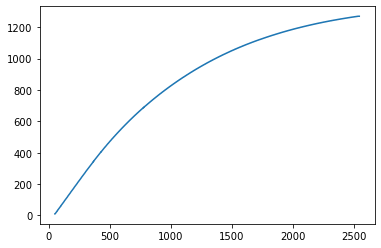

In [22]:
plt.figure()
plt.plot(data[:,0], data[:,2])

In [7]:
process_video(r'.\video2.mp4', 'template.png', save_to_file="output.mp4")

array([[ 354,  314,   11],
       [ 355,  314,   13],
       [ 356,  314,   15],
       ...,
       [1682,  310,  894],
       [1683,  311,  894],
       [1684,  311,  894]], dtype=int64)